# Tech Challenge - Fase 1 (Grupo 40)



**FIAP - Pos Tech - IA para DEVs**

**Professora**: Ana Raquel

**Alunos:**

- Claiton Aparecido Pereira - RM355839
- Eduardo Pedrosa Cajueiro  - RM355819
- Leonardo Lima Ferreira    - RM355721
- Luiz Carvalho             -
- Thiago Cerqueira          -

## Análise e previsão de despesas médicas

O conjunto de dados de seguro médico abrange vários fatores que influenciam as despesas médicas, como idade, sexo, IMC, tabagismo, número de filhos e região. Este conjunto de dados serve de base para o treinamento de modelos de aprendizado de máquina capazes de prever despesas médicas para novos segurados.


# Itens abordados:

* 1 - Exploração inicial dos dados
* 2 - Pré-processamento dos dados
* 3 - Exploração dos dados após ajustes
* 4 - Regressao linear simples
* 5 - Modelo baseado em árvore - DecisionTreeRegressor
* 6 - Modelo baseado em árvore - RandomForestRegressor




# Base de dados

- A base de dados foi obtida do kaggle.com https://www.kaggle.com/datasets/rahulvyasm/medical-insurance-cost-prediction?resource=download :


- **2772** registros
- Não há registros vazios
- **1435** linhas duplicadas
- Após a remoção das linhas duplicas **1337** linhas


# Atributos:

- **age**: idade
- **sex**: Sexo
- **bmi**: indice de massa corporal
- **children**: número de filhos
- **smoker**: fumante
- **region**: região
- **charges**: gasto com o plano de saúde

# Imports necessários para execução

In [79]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm

from scipy import stats

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import roc_curve, roc_auc_score, classification_report

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

#from imblearn.over_sampling import SMOTE
# ! pip install --upgrade imbalanced-learn


# Constantes utilizadas ----------------------------------------------

COL_AGE      = 'age'
COL_SEX      = 'sex'
COL_SMOKER   = 'smoker'
COL_REGION   = 'region'
COL_CHILDREN = 'children'
COL_BMI      = 'bmi'
COL_CHARGES  = 'charges' # target

COL_BMI_TYPES= 'bmi-types'  # categorizacao de bmi
#COL_AGE_TYPES= 'age-types'

DATABASE_NAME = 'medical_insurance.csv'

# variáveis globais ----------------------------------------------------

ratings = pd.DataFrame();

# Functions

In [125]:
# carrega a base de dados
def initialize_database():
  dados = pd.read_csv(DATABASE_NAME)
  #dados = pd.read_csv("medical_insurance.csv") # base do kaggle
  print("base de dados inicializada...")
  return dados


# lista os registros duplicados
def list_duplicated(dados):
  duplicados = dados.duplicated()
  numero_duplicados = duplicados.sum()
  print(f"Número de registros duplicados: {numero_duplicados}")

  linhas_duplicadas = dados[duplicados]
  #print(linhas_duplicadas)


# remove os registros duplicados
def remove_duplicated(dados):
  list_duplicated(dados);
  print(dados.shape)
  print("removendo dados duplicados...")
  # Removendo duplicados (por padrão, mantém a primeira linha)
  dados = dados.drop_duplicates()
  # reindexando a base de dados
  dados = dados.reset_index(drop=True)
  print(dados.shape)
  return dados

# Remoção de valores de gastos (charges) discrepantes, de registros que estão acima de 3 desvios padrão da média
def remove_outliers(dados):
  print("removendo outliers...")
  dados = dados[np.abs(stats.zscore(dados[COL_CHARGES])) <3]
  dados = dados.reset_index(drop=True)
  print(dados.shape)
  return dados


# codifica as colunas categóricas em valores númericos para facilitar o uso em modelos de aprendizado de máquina.
def encoded_labels(dados):
  colunas=['sex','smoker','region']
  print("encoded_labels:", colunas )

  label_encoder = LabelEncoder()
  for col in colunas:
    dados[col] = label_encoder.fit_transform(dados[col])
  return dados


# cria uma nova coluna 'bmi-types' de acordo com o intervalos definidos de classificação BMI
def category_bmi(dados):
  print("categorizando a coluna bmi -> bmi-types")
  #dados.loc[:,"bmi-types"] = pd.cut(dados["bmi"],
  dados[COL_BMI_TYPES] = pd.cut(dados[COL_BMI],
                        bins=[0, 18.5, 24.9, 29.9, 34.9, 39.9, np.inf],
                        labels=[1, 2, 3, 4, 5, 6]).cat.codes

#  if COL_BMI_TYPES != COL_BMI:
#    dados = dados.drop(columns = [COL_BMI]).copy()

  #dados.reset_index(drop=True)
  return dados


# cria uma nova coluna 'age-types' de acordo com as faixas etárias da ANS
#def category_age(dados):
#  print("categorizando a coluna age -> age-types")
#  dados[COL_AGE_TYPES] = pd.cut(dados[COL_AGE],
#                        bins=[0, 18, 23, 28, 33, 38, 43, 48, 53, 59, np.inf],
#                        labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]).cat.codes
##  dados = dados.drop(columns = [COL_AGE]).copy()
  return dados


# insere dados na base de dados até n
def run_upsampling(dados):
  print("run_upsampling")
  dados = dados.sample(n=5000, replace=True, random_state=42, ignore_index=True)
  print(dados.shape)
  return dados


def process_database(dados, duplicated, outliers, upsample):
  if duplicated:
    dados = remove_duplicated(dados)
  if outliers:
    dados = remove_outliers(dados)
  if upsample:
     dados = run_upsampling(dados)
  dados = encoded_labels(dados)
  dados = category_bmi(dados)
 # dados = category_age(dados)
  return dados


# definindo as colunas X para predição e Y (target)
def define_x_y():
  y = dados[COL_CHARGES]
  X = dados[[COL_AGE, COL_SEX, COL_SMOKER, COL_REGION, COL_CHILDREN, COL_BMI, COL_BMI_TYPES]]
  return X, y

# definindo as colunas X para predição e Y (target)
#def define_x_y_age_types():
#  y = dados[COL_CHARGES]
#  X = dados[[COL_AGE_TYPES, COL_SEX, COL_SMOKER, COL_REGION, COL_CHILDREN, COL_BMI_TYPES]]
#  return X, y


# Esta função divide um conjunto de dados em conjuntos de treino e teste, preservando a distribuição de classes na categoria
def process_train_test(X, y, shuffle=True, standard_scaler=False):
    print("ShuffleSplit bmi-types:", shuffle)
    print("StandardScaler:",standard_scaler)
    if shuffle:
      split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)  # este embaralha os dados antes da divisão
#      for train_index, test_index in split.split(X, X[['age-types', 'bmi-types']]):
      for train_index, test_index in split.split(X[[COL_AGE, COL_SEX, COL_SMOKER, COL_REGION, COL_CHILDREN, COL_BMI]], X[COL_BMI_TYPES]):
          shuffe_train = dados.loc[train_index]
          shuffe_test = dados.loc[test_index]


      #print("% base de treino -------------------")
      #print(shuffe_train[COL_BMI_TYPES].value_counts() / len(shuffe_train))

      #print("% base de teste ---------------------")
      #print(shuffe_test[COL_BMI_TYPES].value_counts() / len(shuffe_test))

      if COL_BMI_TYPES != COL_BMI:
        print("removendo coluna bmi-types")
        for set_ in (shuffe_train, shuffe_test):
          set_.drop(COL_BMI_TYPES, axis=1, inplace=True)

      X_train = shuffe_train.copy()
      y_train = X_train[COL_CHARGES].copy()

      X_train = X_train.drop(columns=[COL_CHARGES], axis=1)

      X_test = shuffe_test.copy()
      y_test = X_test[COL_CHARGES].copy()

      X_test = X_test.drop(columns=[COL_CHARGES], axis=1)
    else:
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    if standard_scaler:
      scaler = StandardScaler() #chamando o metodo de padronização dos dados (média e std)
      X_train = scaler.fit_transform(X_train)
      X_test = scaler.transform(X_test)

    return X_train, y_train, X_test, y_test


def calculate_mape(labels, predictions):
    errors = np.abs(labels - predictions)
    relative_errors = errors / np.abs(labels)
    mape = np.mean(relative_errors) * 100
    return mape


# Esta função avalia o desempenho de um modelo de regressão e retorna um dicionário com métricas de desempenho.
def model_evaluate(model, X_train, y_train, X_test, y_test, y_pred):
  #print("Avaliando o desempenho do modelo: ", model.__class__.__name__)
  mse = mean_squared_error(y_test, y_pred)
  mae = mean_absolute_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)
  mape = calculate_mape(y_test, y_pred)
  rmse = np.sqrt(mse);

#  p_values(model, X_train, y_train)

#  print("mse - Mean Squared Error :", mse)
#  print("mae - Mean Absolute Error:", mae)
  print(f"Avaliando o desempenho do modelo: {model.__class__.__name__} - r2-score: {r2}")

#  print("O score nos dá uma visão da precisão média da floresta aleatória nos dados")
#  print("score train: ", model.score(X_train, y_train))
#  print("score test : ", model.score(X_test, y_test))


  print(f"socre train: {model.score(X_train, y_train)} score test: {model.score(X_test, y_test)}")

  score_std, score_mean = validacao_cruzada(model)

  return {'model': model.__class__.__name__,
          'shuffle_split_bmi': shuffle_split,
          'upsampling': upsampling,
          'standard_scaler': standard_scaler,
          'removed_outliers': removed_outliers,
          'mae': mae.round(2),
          'mse': mse.round(2),
          'rmse': rmse.round(2),
          'mape': mape.round(2),
          'r2-score': r2.round(4),
          'k-fold std': score_std,
          'k-fold mean': score_mean  }



# realiza validação cruzada k-fold para avaliar o desempenho de um modelo de regressão e retorna o desvio padrão e a média dos scores de R².
def validacao_cruzada(model, k=10):
  #print("Validação cruzada:", k, model.__class__.__name__,)

  # Realize a validação cruzada e armazene os resultados em 'scores'
  scores = cross_val_score(model, X, y, cv=KFold(n_splits=k, shuffle=True, random_state=42))

#  print("K-Fold (R^2) Scores: {0}".format(scores))
#  print("Desvio padrão do R²:", scores.std())
  #print("Média do R²:", scores.mean())
  return scores.std(), scores.mean()


def plt_real_previsto(y_test, predictions, model):
  plt.scatter(y_test, predictions)
  plt.xlabel('Encargo Real')
  plt.ylabel('Encargo Previsto')
  plt.title('Real vs Previsto - ' + model.__class__.__name__)
  ideal_values = np.linspace(min(y_test), max(y_test))
  plt.plot(ideal_values, ideal_values, color='red', label='Ideal')
  plt.legend()
  plt.show()


# cria, treina e utiliza um modelo de regressão linear para prever valores em um conjunto de dados de teste.
def linear_regression():
  model = LinearRegression()
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  return model, y_pred


# cria, treina e utiliza um modelo de Regressão por Árvore de Decisão para prever valores em um conjunto de dados de teste.
def decision_tree_regressor():
  model = DecisionTreeRegressor(random_state=42)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  return model, y_pred


#  cria, treina e utiliza um modelo de Regressão Random Forest para prever valores em um conjunto de dados de teste.
def radom_forest_regressor():
  model = RandomForestRegressor(n_estimators=100, random_state=42)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  return model, y_pred


def add_rating(evaluation, ratings):
  df = pd.DataFrame([evaluation])
  ratings = pd.concat([ratings, df], ignore_index=True)
  return ratings


def model_run(engine, ratings):
  if (engine == "decision_tree_regressor"):
    model, y_pred = decision_tree_regressor()
  elif (engine == "radom_forest_regressor"):
    model, y_pred = radom_forest_regressor()
  elif (engine == "linear_regression"):
    model, y_pred = linear_regression()

  evaluate = model_evaluate(model, X_train, y_train, X_test, y_test, y_pred)

  ratings = add_rating(evaluate, ratings)

  return model, y_pred, ratings


Em testes

In [119]:
# intervalo de confiança
def intervalo_confianca(X_train, y_train):
  alpha = 0.05 # 95% confidence interval
  lr = sm.OLS(y_train, sm.add_constant(X_train)).fit()
  conf_interval = lr.conf_int(alpha)
  print(conf_interval)


def p_values_regressao_linear(model, X_train, y_train):
  # 2. Calcular os Resíduos
  residuals = y_train - model.predict(X_train)

  # 3. Calcular os P-valores
  n = len(y_train)
  p = X_train.shape[1]  # Número de preditores

  df = n - p - 1  # Graus de liberdade
  mse = np.mean(residuals ** 2)  # Erro médio quadrático

  print (f"n: {n} p: {p} mse: {mse}")

  se = np.sqrt(mse / np.sum((X_train - np.mean(X_train, axis=0)) ** 2, axis=0))
  t_values = model.coef_ / se  # Estatística t
  p_values = 2 * (1 - stats.t.cdf(np.abs(t_values), df))  # P-valores (bicaudal)

  # 4. Interpretar os P-valores
  significance_level = 0.05
  significant_coefficients = p_values < significance_level

  # Exibir os resultados da validação da eficácia do modelo
  print("Verificacação da eficácia do modelo com p-values:")
  for i, coef in enumerate(model.coef_):
      print(f"Coeficiente {i}: valor: {coef} p-value: {p_values[i]}")
      if significant_coefficients[i]:
          print("  Coeficiente estatisticamente significativo.")
      else:
          print("  Coeficiente NÃO é estatisticamente significativo.")

import numpy as np
from scipy import stats



def p_values_regressao_forest(model, X_train, y_train):
    # 2. Calcular os Resíduos
    residuals = y_train - model.predict(X_train)

    # 3. Calcular os P-valores
    n = len(y_train)
    p = X_train.shape[1]  # Número de preditores

    df = n - p - 1  # Graus de liberdade
    mse = np.mean(residuals ** 2)  # Erro médio quadrático
    print(f"n: {n} p: {p} mse: {mse}")

    # 3.1 Calculando o erro padrão
    mse_boot = []
    for _ in range(1000):  # Bootstrap para estimar o erro padrão
        indices = np.random.choice(np.arange(n), n, replace=True)
        X_boot, y_boot = X_train[indices], y_train[indices]
        model.fit(X_boot, y_boot)
        residuals_boot = y_boot - model.predict(X_boot)
        mse_boot.append(np.mean(residuals_boot ** 2))
    se = np.sqrt(np.mean(mse_boot))

    # 3.2 Calculando a estatística t e p-valores
    feature_importances = model.feature_importances_
    t_values = feature_importances / se
    p_values = 2 * (1 - stats.t.cdf(np.abs(t_values), df))

    # 4. Interpretar os P-valores
    significance_level = 0.05
    significant_features = p_values < significance_level

    # Exibir os resultados da validação da eficácia do modelo
    print("Verificação da eficácia do modelo com p-values:")
    for i, importance in enumerate(feature_importances):
        print(f"Feature {i}: Importância: {importance} p-value: {p_values[i]}")
        if significant_features[i]:
            print("  Feature estatisticamente significativa.")
        else:
            print("  Feature NÃO é estatisticamente significativa.")

# 1 - Exploração inicial dos dados

- Inicializando a base de dados

In [82]:
# dados = pd.read_csv("insurance2.csv")
dados = pd.read_csv(DATABASE_NAME)


In [83]:
dados.smoker.value_counts(normalize=True)

smoker
no     0.796537
yes    0.203463
Name: proportion, dtype: float64

In [84]:
dados.sex.value_counts(normalize=True)

sex
male      0.507215
female    0.492785
Name: proportion, dtype: float64

In [85]:
dados.region.value_counts(normalize=True)

region
southeast    0.276335
southwest    0.246753
northwest    0.239538
northeast    0.237374
Name: proportion, dtype: float64

In [86]:
dados.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [87]:
dados.shape

(2772, 7)

In [88]:
dados

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
2767,47,female,45.320,1,no,southeast,8569.86180
2768,21,female,34.600,0,no,southwest,2020.17700
2769,19,male,26.030,1,yes,northwest,16450.89470
2770,23,male,18.715,0,no,northwest,21595.38229


In [89]:
dados.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [90]:
dados.describe().T

,count,mean,std,min,25%,50%,75%,max
age,2772.0,39.109668,14.081459,18.0000,26.000,39.00000,51.0000,64.00000
bmi,2772.0,30.701349,6.129449,15.9600,26.220,30.44750,34.7700,53.13000
children,2772.0,1.101732,1.214806,0.0000,0.000,1.00000,2.0000,5.00000
charges,2772.0,13261.369959,12151.768945,1121.8739,4687.797,9333.01435,16577.7795,63770.42801


In [91]:
dados.groupby(COL_SEX).describe()

age                                                         bmi  \
         count       mean        std   min   25%   50%   75%   max   count   
sex                                                                          
female  1366.0  39.481698  14.093176  18.0  27.0  40.0  52.0  64.0  1366.0   
male    1406.0  38.748222  14.065654  18.0  26.0  39.0  51.0  64.0  1406.0   

                   ... children      charges                              \
             mean  ...      75%  max   count          mean           std   
sex                ...                                                     
female  30.434473  ...      2.0  5.0  1366.0  12486.831977  11049.445434   
male    30.960633  ...      2.0  5.0  1406.0  14013.872721  13094.571070   

                                                                      
              min          25%        50%           75%          max  
sex                                                                   
female  1607.5101  4804.400100  9283.5620  14418.154925  63770.42801  
male    1121.8739  4523.184438  9361.3268  19160.177000  62592.87309  

[2 rows x 32 columns]

In [92]:
dados.groupby(COL_SMOKER).describe()

age                                                         bmi  \
         count       mean        std   min   25%   50%   75%   max   count   
smoker                                                                       
no      2208.0  39.275362  14.114949  18.0  26.0  39.0  52.0  64.0  2208.0   
yes      564.0  38.460993  13.943055  18.0  27.0  37.5  49.0  64.0   564.0   

                   ... children      charges                              \
             mean  ...      75%  max   count          mean           std   
smoker             ...                                                     
no      30.665765  ...      2.0  5.0  2208.0   8417.874411   6015.568209   
yes     30.840656  ...      2.0  5.0   564.0  32223.139764  11521.258969   

                                                                         
               min           25%         50%           75%          max  
smoker                                                                   
no       1121.8739   3953.906862   7341.4160  11354.085925  36910.60803  
yes     12829.4551  20984.093600  34725.8811  41097.161750  63770.42801  

[2 rows x 32 columns]

In [93]:
dados.groupby(COL_REGION).describe()

age                                                         bmi  \
           count       mean        std   min   25%   50%    75%   max  count   
region                                                                         
northeast  658.0  39.243161  14.005929  18.0  27.0  39.0  51.00  64.0  658.0   
northwest  664.0  39.081325  14.092862  19.0  26.0  39.0  51.25  64.0  664.0   
southeast  766.0  38.762402  14.273095  18.0  26.0  39.0  51.00  64.0  766.0   
southwest  684.0  39.397661  13.948653  19.0  27.0  39.0  51.00  64.0  684.0   

                      ... children      charges                              \
                mean  ...      75%  max   count          mean           std   
region                ...                                                     
northeast  29.157781  ...      2.0  5.0   658.0  13475.874737  11310.618603   
northwest  29.147259  ...      2.0  5.0   664.0  12463.129315  10996.174365   
southeast  33.478773  ...      2.0  5.0   766.0  14748.777706  14138.464968   
southwest  30.584503  ...      2.0  5.0   684.0  12164.196435  11419.830441   

                                                                           
                 min          25%          50%           75%          max  
region                                                                     
northeast  1694.7964  5209.578850  10072.05505  16776.304050  58571.07448  
northwest  1621.3402  4733.635288   9081.14720  15153.617225  60021.39897  
southeast  1121.8739  4349.725100   9140.95100  19534.924300  63770.42801  
southwest  1241.5650  4746.344000   8790.53100  13390.559000  52590.82939  

[4 rows x 32 columns]

In [94]:
dados.groupby(COL_CHILDREN).describe()

age                                                          bmi  \
           count       mean        std   min    25%   50%   75%   max   count   
children                                                                        
0         1186.0  38.431703  16.433550  18.0  22.00  36.0  55.0  64.0  1186.0   
1          672.0  39.300595  12.128551  18.0  30.00  40.0  49.0  64.0   672.0   
2          496.0  39.286290  11.776826  18.0  29.75  40.0  48.0  64.0   496.0   
3          324.0  41.395062  12.238779  18.0  31.00  41.0  52.0  64.0   324.0   
4           52.0  38.769231  11.833179  18.0  29.00  38.0  48.0  61.0    52.0   
5           42.0  35.904762   9.672212  19.0  28.00  39.0  43.0  52.0    42.0   

                     ...                charges                              \
               mean  ...     75%    max   count          mean           std   
children             ...                                                      
0         30.628508  ...  34.865  53.13  1186.0  12317.920881  11983.528943   
1         30.705744  ...  34.385  52.58   672.0  12722.650521  11859.598348   
2         31.035806  ...  35.555  48.07   496.0  15268.182723  13163.847347   
3         30.580000  ...  34.320  46.53   324.0  15304.070620  12283.730097   
4         31.314615  ...  33.660  41.47    52.0  13550.983876   8994.512465   
5         28.915000  ...  31.900  46.75    42.0   8706.036629   3549.240196   

                                                                          
                min          25%          50%           75%          max  
children                                                                  
0         1121.8739  2727.395100   9850.43200  14394.557900  63770.42801  
1         1711.0268  4776.207225   8483.87015  15632.052050  58571.07448  
2         2304.0022  6169.665100   9264.97915  21138.760025  49577.66240  
3         3443.0640  6652.528800  10580.52000  19199.944000  60021.39897  
4         4504.6624  7243.813600  11024.41820  17128.426080  40182.24600  
5         4687.7970  5615.369000   8596.82780  10096.970000  19023.26000  

[6 rows x 24 columns]

<Axes: xlabel='sex', ylabel='Count'>

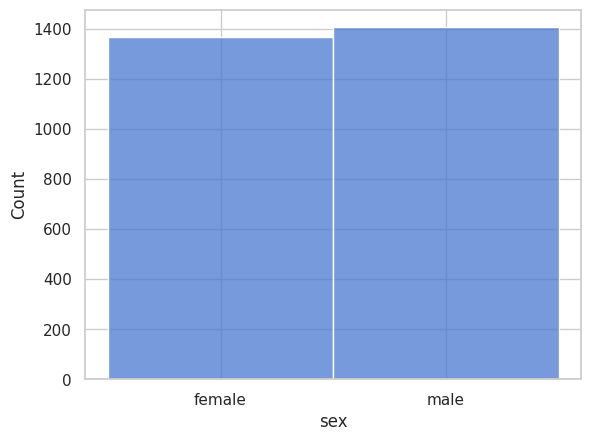

In [95]:
sb.histplot(data=dados, x=COL_SEX)

<Axes: xlabel='children', ylabel='Count'>

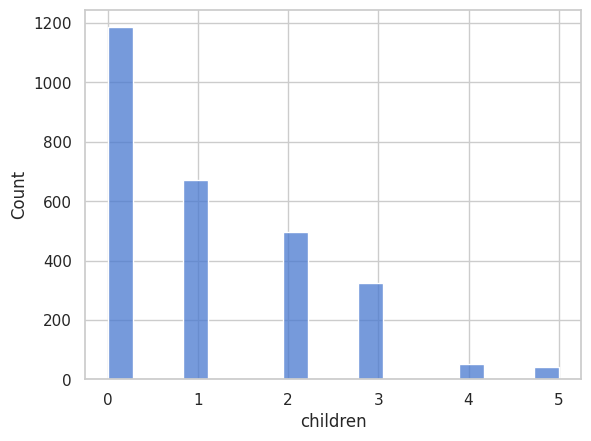

In [96]:
sb.histplot(data=dados, x=COL_CHILDREN)

<Axes: xlabel='bmi', ylabel='Count'>

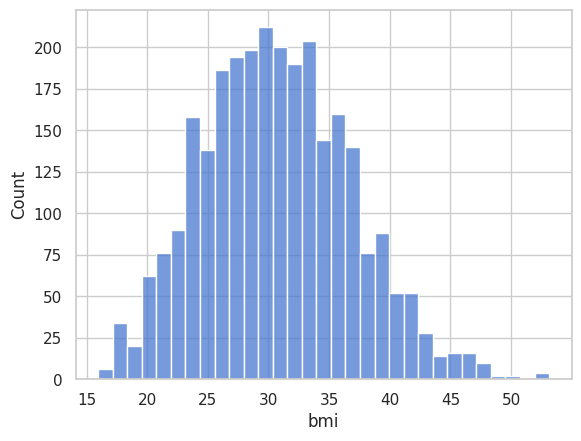

In [97]:
sb.histplot(data=dados, x=COL_BMI)

<Axes: ylabel='charges'>

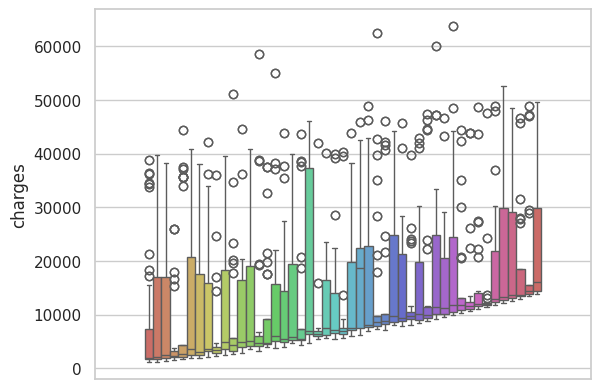

In [98]:
sb.boxplot(hue=COL_AGE, y=COL_CHARGES, data=dados, palette='hls', legend=False)

**Obs:** Pode ser observado nesse gráfico, a relação da idade e dos gastos, que com o avanço da idade os gastos vão aumentando....

<Axes: xlabel='smoker', ylabel='charges'>

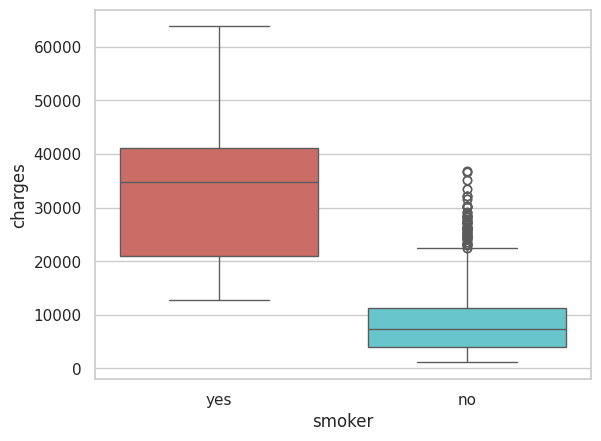

In [99]:
sb.boxplot(x=COL_SMOKER, y=COL_CHARGES, hue=COL_SMOKER, data=dados, palette='hls', legend=False)

**Obs:** Nesse gráfico pode ser observado que o fumante tem um gasto maior, em relação ao não fumante.

<Axes: xlabel='sex', ylabel='charges'>

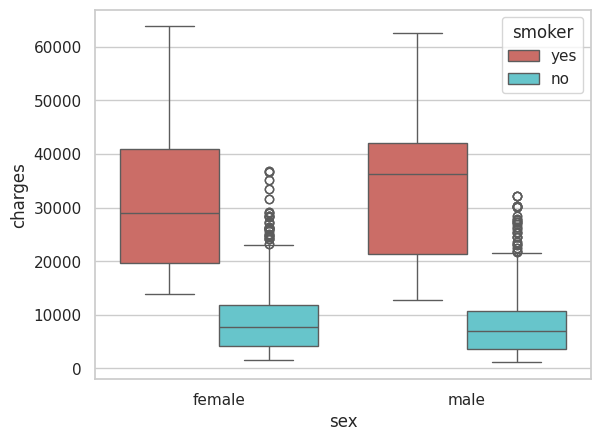

In [100]:

sb.boxplot(x=COL_SEX, y=COL_CHARGES, hue=COL_SMOKER, data=dados, palette='hls', legend=True)

<Axes: xlabel='charges'>

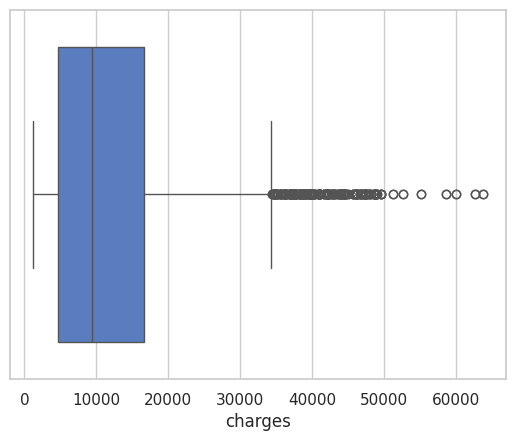

In [101]:
sb.boxplot(x=dados[COL_CHARGES])

<Axes: xlabel='bmi'>

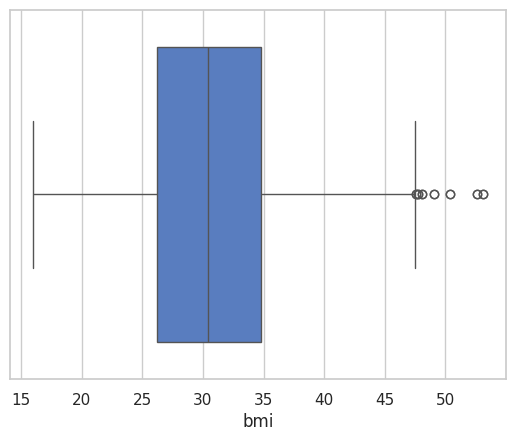

In [102]:
sb.boxplot(x=dados[COL_BMI])

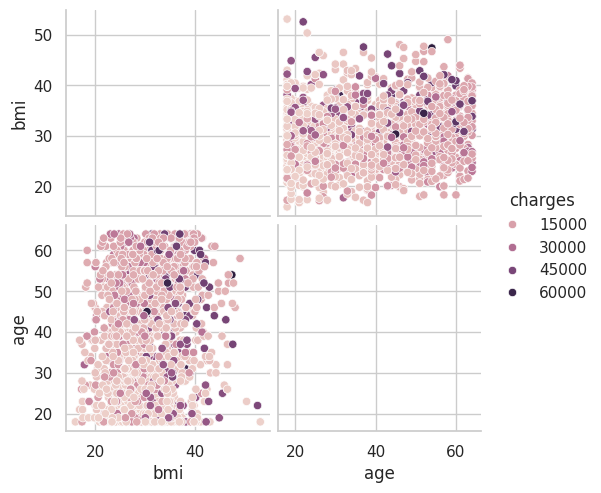

In [103]:
sb.pairplot(dados,vars=[COL_BMI, COL_AGE],hue=COL_CHARGES)

**Obs:** Nesses gráficos, pode ser observar que quanto maior o bmi (indice de massa corportal) maior o gasto com o plano de saúde, o mesmo com  avanço da idade.

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 75.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 58.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 62.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 83.3% of the points cannot be plac

[Text(13.000000000000002, 0.5, '')]

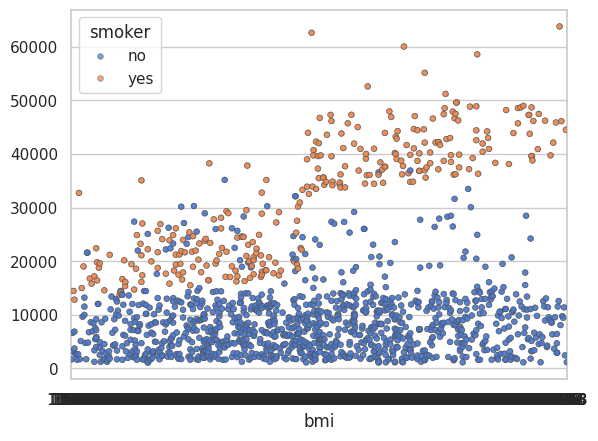

In [104]:
sb.set_theme(style="whitegrid", palette="muted")
ax = sb.swarmplot(data=dados, x=COL_BMI, y=COL_CHARGES, hue=COL_SMOKER, size=4, linewidth=0.5,  alpha=0.7)
ax.set(ylabel="")

**Obs:** Aqui neste gráfico (smoker, bmi e charges), pode perceber que fumantes tem mais gastos com o plano de saude e quanto mais alto IMC o gasto vai aumentando


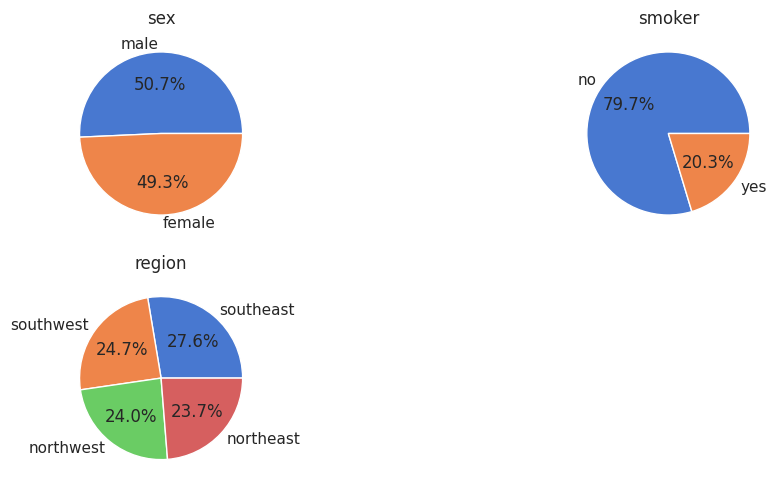

In [105]:
plt.figure(figsize=(12,9))
for i,col in enumerate([COL_SEX, COL_SMOKER, COL_REGION]):
    plt.subplot(3,2,i+1)
    x=dados[col].value_counts().reset_index()
    plt.title(col)
    plt.pie(x=x['count'],labels=x[col],autopct="%0.1f%%",colors=sns.color_palette('muted'))

#2 - Pré-processando os dados

Foram utilizadas as seguintes funcionalidades:

- Eliminação  de registros duplicados;
- Removendo outliers
- Label enconder;
- Categorizando 'bmi';
- Categorizando 'age' (não foi utilizada);
- Upsampling
- StandardScaler

**2.1 - Eliminação de Registros duplicados**


* Listando os registros duplicados da base de dados




In [106]:
list_duplicated(dados)

Número de registros duplicados: 1435


- removendo os registros duplicados

In [107]:

dados = remove_duplicated(dados)


Número de registros duplicados: 1435
(2772, 7)
removendo dados duplicados...
(1337, 7)


**2.2 - Removendo outliers**

Remoção de valores de gastos (charges) discrepantes, de registros que estão acima de 3 desvios padrão da média

In [108]:
dados = remove_outliers(dados)

removendo outliers...
(1330, 7)


remoção de valores discrepantes com base nas pontuações **z** em um conjunto de dados​. Quando aplicamos a regra dos **3 desvios padrão**, estamos considerando que mais de **99%** dos dados estão dentro deste intervalo em uma distribuição normal.
Assim, os valores que estão além de 3 desvios padrão da média são considerados incomuns ou **outliers**.

**OBS:**  **7** registros excluidos, considerados outliers

**2.3 - LabelEncoder**

Vamos utilizar **label enconder** para tratar variáveis categóricas: **sex, smoker e region**

In [109]:
dados = encoded_labels(dados)

dados.head()

encoded_labels: ['sex', 'smoker', 'region']


,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


**2.4 - Categorizando BMI**

**`O índice de massa corporal ( IMC )`** é um valor derivado da massa ( peso ) e altura de uma pessoa. O IMC é definido como a massa corporal dividida pelo quadrado da altura corporal e é expresso em unidades de kg/m 2




IMC, categorias básicas Categoria	IMC (kg/m 2 )
- Abaixo do peso (magreza severa):	< 16,0
- Abaixo do peso (magreza moderada):	16,0 – 16,9
- Abaixo do peso (magreza leve):	17,0 – 18,4
- Intervalo normal:	18,5 – 24,9
- Excesso de peso (pré-obeso):	25,0 – 29,9
- Obeso (Classe I):	30,0 – 34,9
- Obeso (Classe II):	35,0 – 39,9
- Obeso (Classe III):	≥ 40,0

In [110]:
dados = category_bmi(dados)
dados[COL_BMI_TYPES]

categorizando a coluna bmi -> bmi-types


0       2
1       3
2       3
3       1
4       2
       ..
1325    3
1326    3
1327    4
1328    2
1329    2
Name: bmi-types, Length: 1330, dtype: int8

**2.5 - Categorizando Age**

**Categorizando idades por faixas etárias**

Faixas definidas pela  ANS - Agência Nacional de Saúde Suplementar:

- 0 a 18 anos
- 19 a 23 anos
- 24 a 28 anos
- 29 a 33 anos
- 34 a 38 anos
- 39 a 43 anos
- 44 a 48 anos
- 49 a 53 anos
- 54 a 58 anos
- 59 anos ou mais

In [111]:
#dados = category_age(dados)
#dados[COL_AGE_TYPES]

**2.6 - Upsampling**

**Upsampling** é uma técnica de manipulação de dados usada para resolver o desequilíbrio de classes em conjuntos de dados, mas é importante considerar suas limitações, como **Overfitting**

In [112]:
dados = run_upsampling(dados)

upsampling = True
dados.shape


run_upsampling
(5000, 8)


(5000, 8)

**2.7 - StandardScaler**

**Obs:** Não há melhoras no modelo, usando StandardScaler

In [113]:
X, y = define_x_y()

standard_scaler = True
shuffle_split = False
X_train, y_train, X_test, y_test = process_train_test(X, y, shuffle_split, standard_scaler)

ShuffleSplit bmi-types: False
StandardScaler: True


# 3 - Exploração de dados após ajustes

In [38]:
dados.head()


,age,sex,bmi,children,smoker,region,charges,bmi-types
0,27,1,45.900,2,0,3,3693.42800,5
1,40,1,29.900,2,0,3,6600.36100,2
2,25,0,20.800,1,0,3,3208.78700,1
3,50,0,28.120,3,0,1,11085.58680,2
4,33,0,19.095,2,1,0,16776.30405,1


In [39]:
dados.describe().T

,count,mean,std,min,25%,50%,75%,max
age,5000.0,39.307200,14.138473,18.0000,26.0000,40.0000,51.00000,64.0000
sex,5000.0,0.498800,0.500049,0.0000,0.0000,0.0000,1.00000,1.0000
bmi,5000.0,30.767418,6.105264,15.9600,26.4000,30.4950,34.80000,53.1300
children,5000.0,1.087000,1.203046,0.0000,0.0000,1.0000,2.00000,5.0000
smoker,5000.0,0.199000,0.399288,0.0000,0.0000,0.0000,0.00000,1.0000
region,5000.0,1.525400,1.090134,0.0000,1.0000,2.0000,2.00000,3.0000
charges,5000.0,12989.817179,11561.228404,1121.8739,4753.6368,9432.9253,16420.49455,49577.6624
bmi-types,5000.0,2.666000,1.191943,0.0000,2.0000,3.0000,3.00000,5.0000


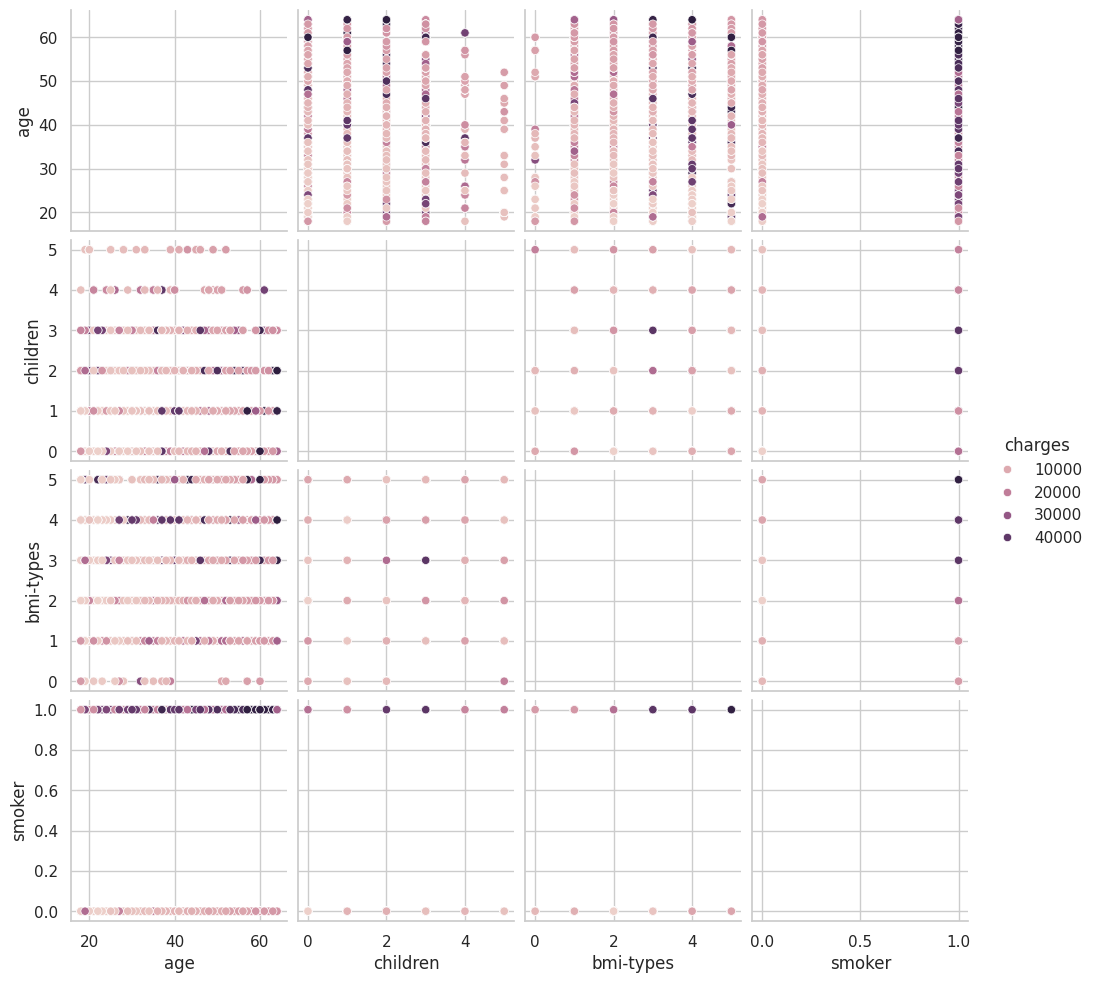

In [40]:
sb.pairplot(dados,vars=[COL_AGE, COL_CHILDREN, COL_BMI_TYPES, COL_SMOKER],hue=COL_CHARGES)


**3.2 - Correlações**

<Axes: >

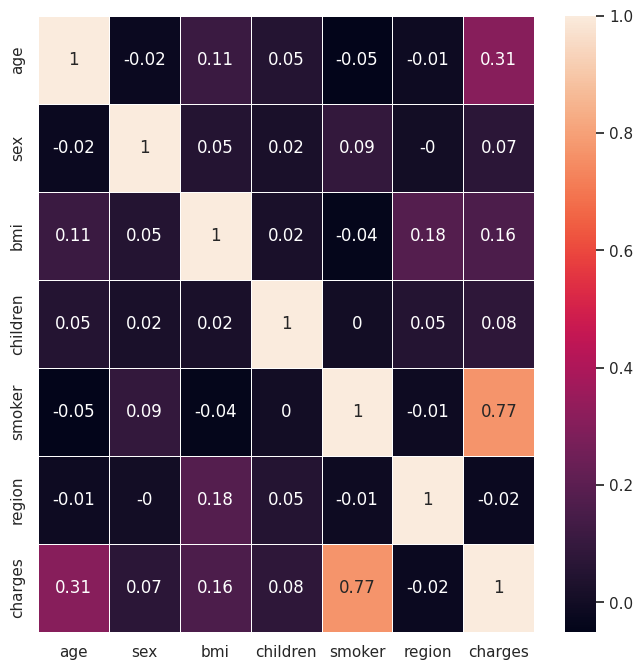

In [118]:
dados_corr = dados.drop(columns=[COL_BMI_TYPES])
correlation_matrix = dados_corr.corr().round(2)
fig, ax = plt.subplots(figsize=(8,8))
sb.heatmap(data=correlation_matrix, annot=True, linewidths=.5, ax=ax)

**obs:** pode ser percebido que a correlação dos gastos com a pessoa fumante é alta de 0,79 e com bmi de 0,20 e de idade 0,32

In [117]:
dados_corr = dados.drop(columns=[COL_BMI_TYPES])
correlation_matrix = dados_corr.corr()
max_corr = correlation_matrix.stack().sort_values(ascending=False).drop_duplicates()
max_corr = max_corr[max_corr < 1].head(10)

print("Maiores correlações:")
print(max_corr)

Maiores correlações:
smoker    charges     0.770091
charges   age         0.308042
region    bmi         0.184009
bmi       charges     0.161940
          age         0.108059
sex       smoker      0.089863
charges   children    0.079997
          sex         0.074807
age       children    0.048399
children  region      0.045980
dtype: float64


# 4 - Modelo baseado Regressão Linear

**Run model linear regression**

In [126]:
dados = pd.read_csv(DATABASE_NAME)

removed_duplicated = True
removed_outliers = True
upsampling = True
dados = process_database(dados, removed_duplicated, removed_outliers, upsampling)

X, y = define_x_y()

standard_scaler = False
shuffle_split = True
X_train, y_train, X_test, y_test = process_train_test(X, y, shuffle_split, standard_scaler)

ratings = pd.DataFrame();

model, y_pred, ratings = model_run("linear_regression", ratings)

ratings.head(40)

Número de registros duplicados: 1435
(2772, 7)
removendo dados duplicados...
(1337, 7)
removendo outliers...
(1330, 7)
run_upsampling
(5000, 7)
encoded_labels: ['sex', 'smoker', 'region']
categorizando a coluna bmi -> bmi-types
ShuffleSplit bmi-types: True
StandardScaler: False
removendo coluna bmi-types
Avaliando o desempenho do modelo: LinearRegression - r2-score: 0.7207186720963925
socre train: 0.745221835522679 score test: 0.7207186720963925


,model,shuffle_split_bmi,upsampling,standard_scaler,removed_outliers,mae,mse,rmse,mape,r2-score,k-fold std,k-fold mean
0,LinearRegression,True,True,False,True,4185.57,35149664.27,5928.72,41.1,0.7207,0.022698,0.739094


**Visualizando previsões**

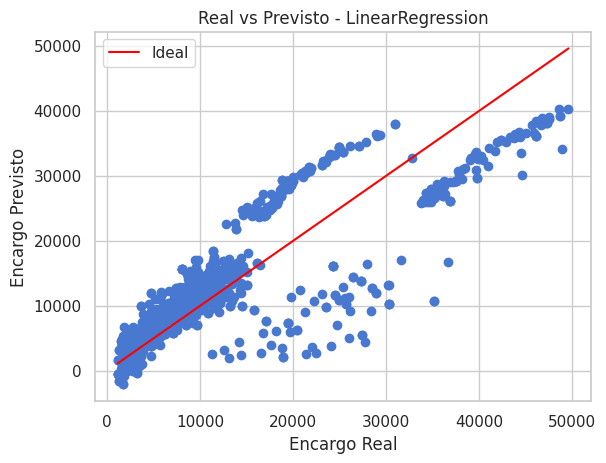

In [127]:
plt_real_previsto(y_test, y_pred, model)

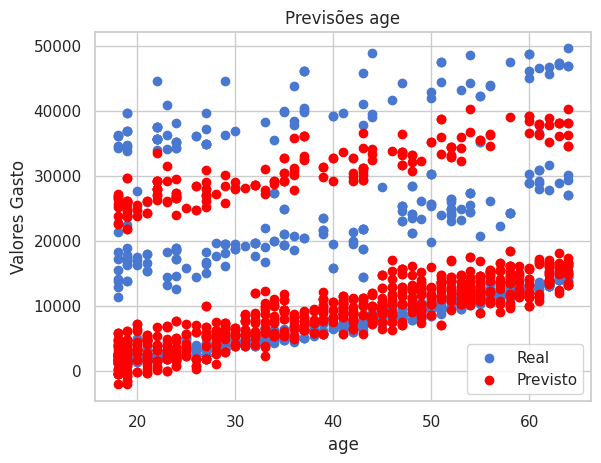

In [128]:
feature = COL_AGE

plt.scatter(X_test[feature], y_test, label='Real')
plt.scatter(X_test[feature], y_pred, label='Previsto', color='red')
plt.xlabel(feature)
plt.ylabel('Valores Gasto')
plt.title('Previsões age')
plt.legend()
plt.show()



# 5 - Modelo baseado em árvore (DecisionTreeRegressor) - - - - - - - - - - - -



**Run model decision_tree_regressor**

In [129]:
dados = pd.read_csv(DATABASE_NAME)

removed_duplicated = True
removed_outliers = True
upsampling = True
dados = process_database(dados, removed_duplicated, removed_outliers, upsampling)

X, y = define_x_y()

standard_scaler = False
shuffle_split = True
X_train, y_train, X_test, y_test = process_train_test(X, y, shuffle_split, standard_scaler)

ratings = pd.DataFrame();

model, y_pred, ratings = model_run("decision_tree_regressor", ratings)

ratings.head(40)

Número de registros duplicados: 1435
(2772, 7)
removendo dados duplicados...
(1337, 7)
removendo outliers...
(1330, 7)
run_upsampling
(5000, 7)
encoded_labels: ['sex', 'smoker', 'region']
categorizando a coluna bmi -> bmi-types
ShuffleSplit bmi-types: True
StandardScaler: False
removendo coluna bmi-types
Avaliando o desempenho do modelo: DecisionTreeRegressor - r2-score: 0.989047591621474
socre train: 0.998573131899907 score test: 0.989047591621474


,model,shuffle_split_bmi,upsampling,standard_scaler,removed_outliers,mae,mse,rmse,mape,r2-score,k-fold std,k-fold mean
0,DecisionTreeRegressor,True,True,False,True,121.54,1378443.31,1174.07,1.67,0.989,0.006788,0.991073


**Visualizando as previsões**

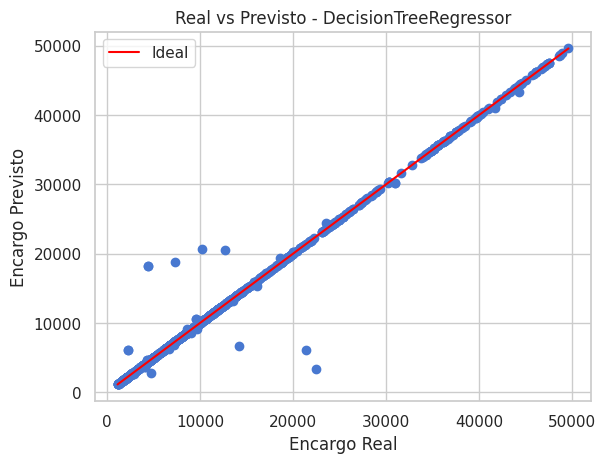

In [130]:
plt_real_previsto(y_test, y_pred, model)

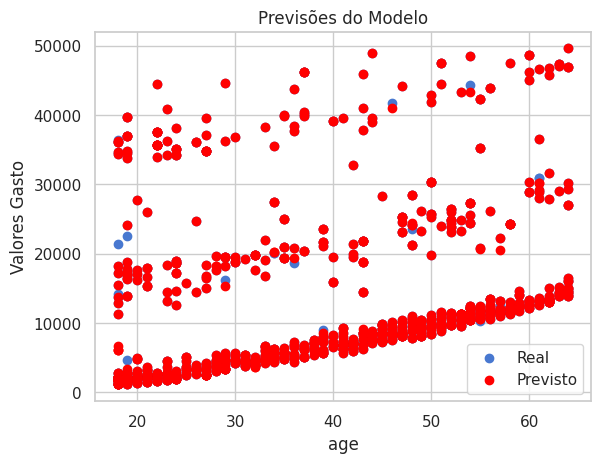

In [131]:
feature = COL_AGE

plt.scatter(X_test[feature], y_test, label='Real')
plt.scatter(X_test[feature], y_pred, label='Previsto', color='red')
plt.xlabel(feature)
plt.ylabel('Valores Gasto')
plt.title('Previsões do Modelo')
plt.legend()
plt.show()

# 6 - Modelo baseado em árvore (RandomForestRegressor) - - - - - - - - - - - - - -

**Run model random_forest_regressor**

In [132]:
dados = pd.read_csv(DATABASE_NAME)

removed_duplicated = True
removed_outliers = True
upsampling = True
dados = process_database(dados, removed_duplicated, removed_outliers, upsampling)

X, y = define_x_y()

standard_scaler = False # não melhora
shuffle_split = True
X_train, y_train, X_test, y_test = process_train_test(X, y, shuffle_split, standard_scaler)

#ratings = pd.DataFrame();

model, y_pred, ratings = model_run("radom_forest_regressor", ratings)

ratings.head(40)

Número de registros duplicados: 1435
(2772, 7)
removendo dados duplicados...
(1337, 7)
removendo outliers...
(1330, 7)
run_upsampling
(5000, 7)
encoded_labels: ['sex', 'smoker', 'region']
categorizando a coluna bmi -> bmi-types
ShuffleSplit bmi-types: True
StandardScaler: False
removendo coluna bmi-types
Avaliando o desempenho do modelo: RandomForestRegressor - r2-score: 0.9894423107849946
socre train: 0.9970451417953896 score test: 0.9894423107849946


,model,shuffle_split_bmi,upsampling,standard_scaler,removed_outliers,mae,mse,rmse,mape,r2-score,k-fold std,k-fold mean
0,DecisionTreeRegressor,True,True,False,True,121.54,1378443.31,1174.07,1.67,0.9890,0.006788,0.991073
1,RandomForestRegressor,True,True,False,True,338.49,1328764.92,1152.72,4.33,0.9894,0.003811,0.990162


**Vizualizando as previsões**

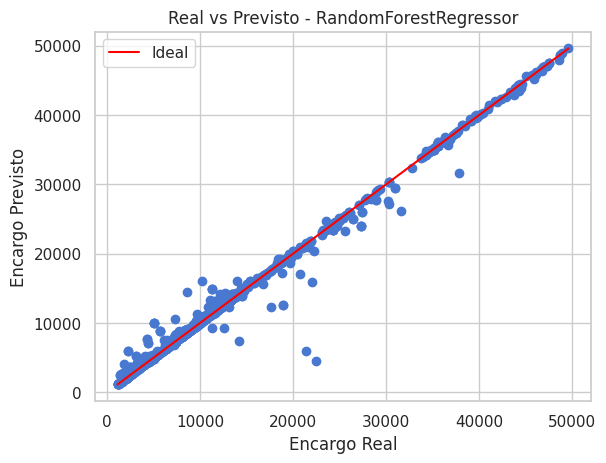

In [133]:
plt_real_previsto(y_test, y_pred, model)

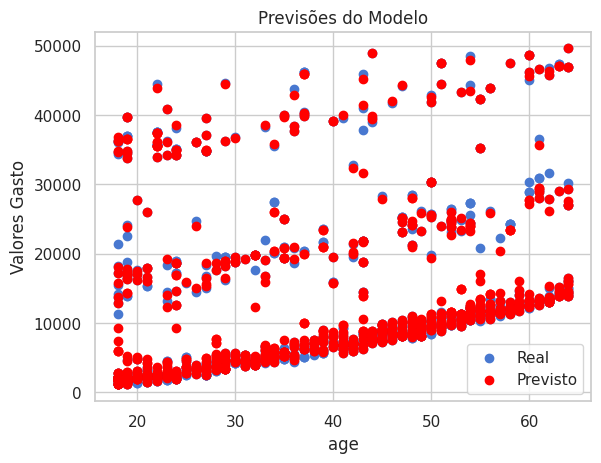

In [134]:
feature =  COL_AGE

plt.scatter(X_test[feature], y_test, label='Real')
plt.scatter(X_test[feature], y_pred, label='Previsto', color='red')
plt.xlabel(feature)
plt.ylabel('Valores Gasto')
plt.title('Previsões do Modelo')
plt.legend()
plt.show()

# 7 - Executando todos os modelos

**Inicializando e processando a base dados**

In [135]:
dados = pd.read_csv(DATABASE_NAME)

removed_duplicated = True
removed_outliers = False
upsampling = True

dados = process_database(dados, removed_duplicated, removed_outliers, upsampling)

#ratings = pd.DataFrame();

Número de registros duplicados: 1435
(2772, 7)
removendo dados duplicados...
(1337, 7)
run_upsampling
(5000, 7)
encoded_labels: ['sex', 'smoker', 'region']
categorizando a coluna bmi -> bmi-types


**Run modelos**

In [137]:
ratings = pd.DataFrame();

X, y = define_x_y()

standard_scaler = False

shuffle_split = False
X_train, y_train, X_test, y_test = process_train_test(X, y, shuffle_split, standard_scaler)

model, y_pred, ratings = model_run("linear_regression", ratings)
model, y_pred, ratings = model_run("decision_tree_regressor", ratings)
model, y_pred, ratings = model_run("radom_forest_regressor", ratings)

shuffle_split = True
X_train, y_train, X_test, y_test = process_train_test(X, y, shuffle_split, standard_scaler)

model, y_pred, ratings = model_run("linear_regression", ratings)
model, y_pred, ratings = model_run("decision_tree_regressor", ratings)
model, y_pred, ratings = model_run("radom_forest_regressor", ratings)

print("\nResultado: Ordenado pelo melhor r2")
ratings.sort_values(by='r2-score', ascending=False)

ShuffleSplit bmi-types: False
StandardScaler: False
Avaliando o desempenho do modelo: LinearRegression - r2-score: 0.7720632481838658
socre train: 0.7497440942878382 score test: 0.7720632481838658
Avaliando o desempenho do modelo: DecisionTreeRegressor - r2-score: 0.9789886215624491
socre train: 0.9993880395729559 score test: 0.9789886215624491
Avaliando o desempenho do modelo: RandomForestRegressor - r2-score: 0.9828696436812351
socre train: 0.9978755143392981 score test: 0.9828696436812351
ShuffleSplit bmi-types: True
StandardScaler: False
removendo coluna bmi-types
Avaliando o desempenho do modelo: LinearRegression - r2-score: 0.7330816821046513
socre train: 0.7582880805294319 score test: 0.7330816821046513
Avaliando o desempenho do modelo: DecisionTreeRegressor - r2-score: 0.9810212967352167
socre train: 0.9993877893657712 score test: 0.9810212967352167
Avaliando o desempenho do modelo: RandomForestRegressor - r2-score: 0.981530431502059
socre train: 0.9979711384679211 score test: 

,model,shuffle_split_bmi,upsampling,standard_scaler,removed_outliers,mae,mse,rmse,mape,r2-score,k-fold std,k-fold mean
2,RandomForestRegressor,False,True,False,False,390.67,2468889.23,1571.27,3.81,0.9829,0.007462,0.988353
5,RandomForestRegressor,True,True,False,False,440.59,2663110.60,1631.90,4.78,0.9815,0.007462,0.988353
4,DecisionTreeRegressor,True,True,False,False,193.74,2736522.29,1654.24,2.00,0.9810,0.007092,0.988403
1,DecisionTreeRegressor,False,True,False,False,199.78,3028236.25,1740.18,1.92,0.9790,0.007092,0.988403
0,LinearRegression,False,True,False,False,4010.89,32851073.37,5731.59,40.56,0.7721,0.026421,0.751505
3,LinearRegression,True,True,False,False,4295.12,38486714.10,6203.77,39.87,0.7331,0.026421,0.751505


In [ ]:
print("Resultado: Ordenado pelo melhor r2")
#ratings.sort_values(by='r2-score', ascending=False)
ratings

**Desempenho do modelo de regressão:**

**- Mean Absolute Error (mae):**

mede a média das diferenças absolutas entre as previsões do modelo e os valores reais. Em termos simples, o MAE nos diz quão distantes, em média, as previsões estão dos valores reais. Quanto menor o valor do MAE, mais precisas são as previsões do modelo. É uma medida direta da qualidade das previsões, sem levar em conta a direção dos erros.

**- Mean Squared Error (mse):**

Em vez de calcular a média das diferenças absolutas entre previsões e valores reais, o MSE calcula a média dos quadrados dessas diferenças. Isso significa que o MSE penaliza erros grandes de forma mais significativa do que erros menores. Assim como o MAE, quanto menor o valor do MSE, melhor o desempenho do modelo. No entanto, como os erros são elevados ao quadrado, o MSE tende a ser mais sensível a valores extremos do que o MAE.

**- Erro Quadrático Médio da Raiz (rmse):**

 é uma versão do MSE que leva em conta a raiz quadrada dos erros quadráticos médios. Em essência, o RMSE é uma medida da dispersão dos erros entre as previsões e os valores reais. Como o MSE, o RMSE também penaliza erros grandes, mas devido à raiz quadrada, sua unidade é a mesma dos dados originais, o que facilita a interpretação. Assim como o MSE, quanto menor o valor do RMSE, melhor o desempenho do modelo de regressão.

**- R² Score (r2):**

é uma métrica que nos ajuda a entender o quanto as variações nas variáveis independentes explicam as variações na variável que estamos tentando prever (variável dependente) em um modelo de regressão. Quanto mais próximo de 1, melhor o modelo está em explicar a variabilidade dos dados. No entanto, é importante observar que o R² Score não indica a qualidade absoluta do modelo, mas sim a adequação do modelo em relação aos dados utilizados.

**- Mean Absolute Percentage Error (mape):**

 é uma métrica usada para avaliar a precisão de previsões em relação aos valores reais, expressando o erro médio como uma porcentagem do valor real. Ele calcula a média das diferenças percentuais absolutas entre as previsões e os valores reais.